##**UNET ARCHITECTURE**

**IMPORTING LIBRARIES**

In [ ]:
# Required Packages

%tensorflow_version 2.1.0
!pip install segmentation-models==1.0.1

In [ ]:
# Data Handling
import numpy as np
import os
import glob
import cv2
import random
import zipfile
from skimage import io
import imutils

# Visualization
from matplotlib import pyplot as plt
%matplotlib inline

# Data Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import get_file
from keras_applications import imagenet_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation

# Import Custom files
import unet_func_block
from unet_func_block import drop_out, conv_block, encoder_block, decoder_block_unet, build_unet, build_autoencoder, build_encoder, build_decoder
import pd_functions
from pd_functions import load_data, load_test_data, visualize, visualize_generated, preprocessing, preprocess_customUnet, data_split
from pd_functions import augment, model_IOU, iou_acc, evaluation, performance, testing, compare_evaluation_2, compare_evaluation_3
from pd_functions import compare_performance, load_model

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.
2.8.0


'tf.keras'

#### ***01 - COMPARISON OF LOSS FUNCTIONS***


*   Binary Cross Entropy
*   Jackard loss 
*   Dice Focal loss



In [ ]:
### DIRECTORY

drive_path = '/content/drive/MyDrive/Colab Notebooks/'
saved_models = '/content/drive/MyDrive/Colab Notebooks/saved_models/'
Train_path = "/data/Train_folder/OriginalTrain"
Mask_path =  "/data/Train_folder/AnnotationsTrain"
test_path = "/content/Testers"

### HYPER-PARAMETERS

# (Data Dynamics)
size = 256
IMG_CHANNELS = 3
input_shape = (size, size, IMG_CHANNELS)

# (Model Parameters)
iou = sm.metrics.iou_score
acc = 'accuracy'
jaccard_loss = sm.losses.bce_jaccard_loss
binary_loss = 'binary_crossentropy'
focal_dice_loss = sm.losses.binary_focal_dice_loss
optimizer = 'Adam'
backbone = 'resnet34'

# (Batch Sizes)
BS16 = 16                            
BS32 = 32

In [ ]:
# Loading Image Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Train_folder.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [ ]:
# Loading Data
train_images, mask_images = load_data(Train_path, Mask_path, size)

print(train_images.shape)
print(mask_images.shape)

(472, 256, 256, 3)
(472, 256, 256)


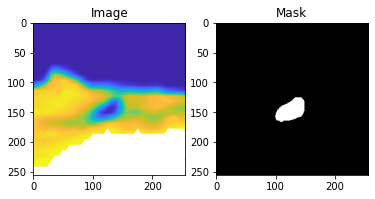

Labels are: [0 1] and label count is: [64175  1361]
Image Number= 45


In [ ]:
# Visualization before preprocessing

img_num = random.randint(0, len(train_images)-1)
V = visualize(train_images, mask_images, img_num)
V

In [ ]:
X, Y = preprocess_customUnet(train_images,mask_images)

print(X.shape)
print(Y.shape)

(472, 256, 256, 3)
(472, 256, 256, 1)


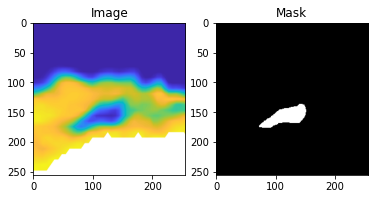

Labels are: [0. 1.] and label count is: [63894  1642]
Image Number= 42


In [ ]:
# Visualizing Preprocessed images

img_num = random.randint(0, len(X)-1)
VP = visualize(X,Y, img_num)
VP

In [ ]:
# Data Split

x_train, y_train, x_val, y_val = data_split(X, Y, split_size = 0.2, random_state = 42)

print("Train Data Dynamics:" , x_train.shape, y_train.shape)
print("Test Data Dynamics:" , x_val.shape, y_val.shape)

Train Data Dynamics: (377, 256, 256, 3) (377, 256, 256, 1)
Test Data Dynamics: (95, 256, 256, 3) (95, 256, 256, 1)


In [ ]:
# First Model Using Binary Cross Entropy Loss 

cross_entropy = build_unet(input_shape)
cross_entropy.compile(optimizer=optimizer, loss= binary_loss, metrics=[iou])
history1 = cross_entropy.fit(x=x_train, y= y_train, batch_size= BS32, epochs= 100, verbose=1, validation_data= (x_val, y_val))

Epoch 1/100
12/12 [==============================] - 35s 1s/step - loss: 0.4581 - iou_score: 0.0149 - val_loss: 11.8184 - val_iou_score: 0.0126
Epoch 2/100
12/12 [==============================] - 10s 830ms/step - loss: 0.1857 - iou_score: 0.0244 - val_loss: 24053.1211 - val_iou_score: 0.0117
Epoch 3/100
12/12 [==============================] - 10s 830ms/step - loss: 0.1216 - iou_score: 0.0486 - val_loss: 130.0813 - val_iou_score: 0.0120
Epoch 4/100
12/12 [==============================] - 10s 830ms/step - loss: 0.0951 - iou_score: 0.0656 - val_loss: 502.1487 - val_iou_score: 0.0114
Epoch 5/100
12/12 [==============================] - 10s 830ms/step - loss: 0.0837 - iou_score: 0.0693 - val_loss: 10.9875 - val_iou_score: 0.0133
Epoch 6/100
12/12 [==============================] - 10s 831ms/step - loss: 0.0728 - iou_score: 0.0869 - val_loss: 24.8273 - val_iou_score: 0.0111
Epoch 7/100
12/12 [==============================] - 10s 833ms/step - loss: 0.0635 - iou_score: 0.0963 - val_loss: 4

In [ ]:
# Second Model Using Jaccard Loss 

jaccard_score = build_unet(input_shape)
jaccard_score.compile(optimizer=optimizer, loss= jaccard_loss, metrics=[iou])
history2 = jaccard_score.fit(x=x_train, y= y_train, batch_size= BS32, epochs= 100, verbose=1, validation_data= (x_val, y_val))

Epoch 1/100
12/12 [==============================] - 13s 875ms/step - loss: 1.6436 - iou_score: 0.0130 - val_loss: 2.1904 - val_iou_score: 0.0117
Epoch 2/100
12/12 [==============================] - 10s 835ms/step - loss: 1.2116 - iou_score: 0.0166 - val_loss: 4.0937 - val_iou_score: 0.0117
Epoch 3/100
12/12 [==============================] - 10s 833ms/step - loss: 1.1486 - iou_score: 0.0210 - val_loss: 2.1683 - val_iou_score: 0.0120
Epoch 4/100
12/12 [==============================] - 10s 832ms/step - loss: 1.1110 - iou_score: 0.0288 - val_loss: 1.5575 - val_iou_score: 0.0112
Epoch 5/100
12/12 [==============================] - 10s 833ms/step - loss: 1.0693 - iou_score: 0.0510 - val_loss: 2.5485 - val_iou_score: 0.0128
Epoch 6/100
12/12 [==============================] - 10s 833ms/step - loss: 1.0370 - iou_score: 0.0683 - val_loss: 127.6414 - val_iou_score: 0.0117
Epoch 7/100
12/12 [==============================] - 10s 833ms/step - loss: 0.9960 - iou_score: 0.0913 - val_loss: 161.269

In [ ]:
# Third Model Using Dice Focal Loss

dice_focal = build_unet(input_shape)
dice_focal.compile(optimizer=optimizer, loss= focal_dice_loss, metrics=[iou])
history3 = dice_focal.fit(x=x_train, y= y_train, batch_size= BS32, epochs= 100, verbose=1, validation_data= (x_val, y_val))

Epoch 1/100
12/12 [==============================] - 15s 972ms/step - loss: 1.1338 - iou_score: 0.0130 - val_loss: 7.9456 - val_iou_score: 0.0119
Epoch 2/100
12/12 [==============================] - 11s 919ms/step - loss: 1.0046 - iou_score: 0.0152 - val_loss: 1.0472 - val_iou_score: 4.2332e-10
Epoch 3/100
12/12 [==============================] - 11s 920ms/step - loss: 0.9742 - iou_score: 0.0202 - val_loss: 1.0473 - val_iou_score: 4.1762e-10
Epoch 4/100
12/12 [==============================] - 11s 921ms/step - loss: 0.9600 - iou_score: 0.0272 - val_loss: 1.1687 - val_iou_score: 0.0100
Epoch 5/100
12/12 [==============================] - 11s 919ms/step - loss: 0.9472 - iou_score: 0.0345 - val_loss: 1.0471 - val_iou_score: 0.0123
Epoch 6/100
12/12 [==============================] - 11s 919ms/step - loss: 0.9117 - iou_score: 0.0557 - val_loss: 1.0203 - val_iou_score: 0.0087
Epoch 7/100
12/12 [==============================] - 11s 921ms/step - loss: 0.8711 - iou_score: 0.0778 - val_loss: 1

In [ ]:
accuracy1 = model_IOU(cross_entropy, x_val, y_val, 0.5)
accuracy2 = model_IOU(jaccard_score, x_val, y_val, 0.5)
accuracy3 = model_IOU(dice_focal, x_val, y_val, 0.5)

print('IOU score with loss function "Binary Cross Entropy Loss" is', f'{accuracy1:.0%}')
print('IOU score with loss function "Jaccard Loss" is', f'{accuracy2:.0%}')
print('IOU score with loss function "Focal Dice Loss" is', f'{accuracy3:.0%}')

IOU score with loss function "Binary Cross Entropy Loss" is 82%
IOU score with loss function "Jaccard Loss" is 34%
IOU score with loss function "Focal Dice Loss" is 77%


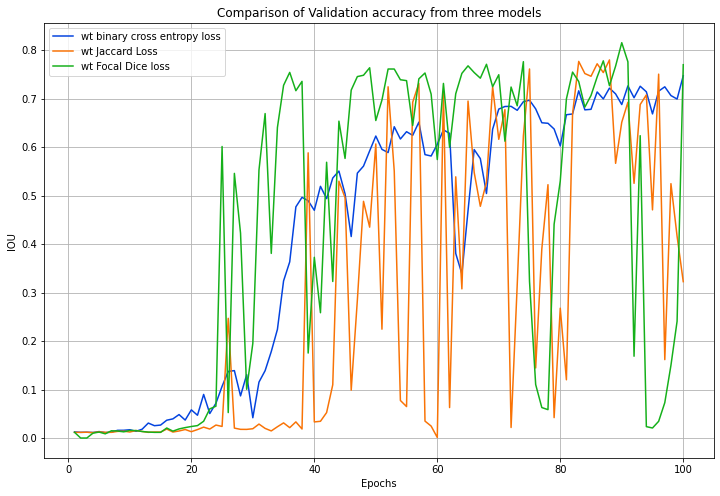

In [ ]:
# Compare performance history of 3 loss functions

LF = compare_evaluation_3(history1, history2, history3, model1 = 'wt binary cross entropy loss', 
                          model2 = 'wt Jaccard Loss',
                          model3 = 'wt Focal Dice loss')
LF

**Performance on Test Images**

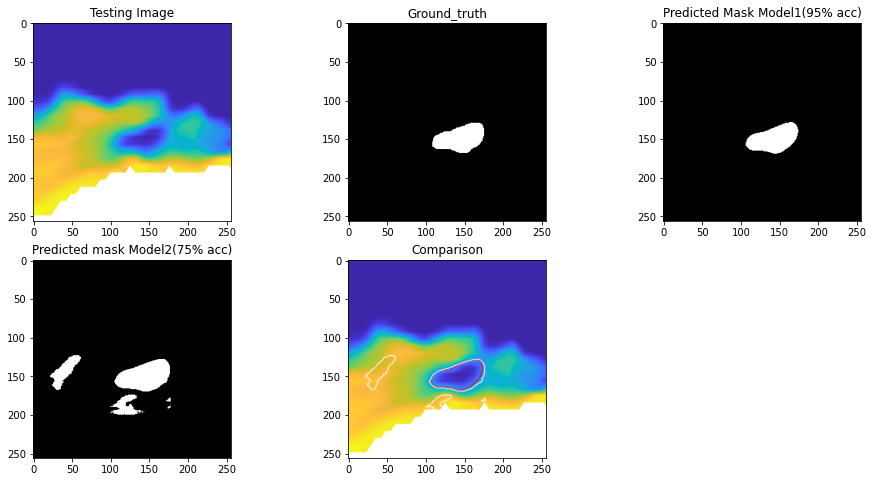

In [ ]:
# Binary Cross ENtropy vs Jaccard Loss

CP2 = compare_performance(x_val, y_val, cross_entropy, jaccard_score, 0.5)


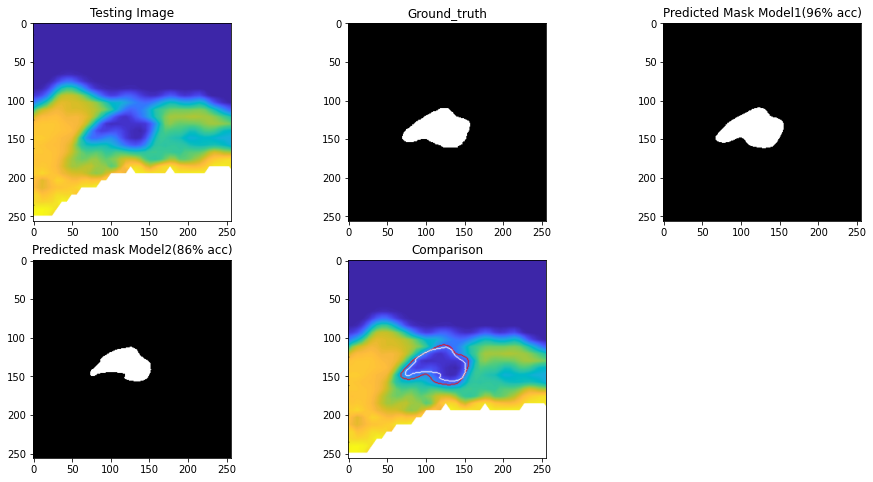

In [ ]:
# Binary Cross Entropy vs Dice Focal Loss

CP3 = compare_performance(x_val, y_val, cross_entropy, dice_focal, 0.5)

In [ ]:
# Saving Models

cross_entropy.save('/content/drive/MyDrive/Colab Notebooks/saved_models/cross_entropy_loss_model.h5')
jaccard_score.save('/content/drive/MyDrive/Colab Notebooks/saved_models/jaccard_loss_model.h5')
dice_focal.save('/content/drive/MyDrive/Colab Notebooks/saved_models/dice_focal_loss_model.h5')

####***02 - AFFECTS OF PRETRAINED WEIGHTS IN TRANSFER LEARNING***



*   Model 1 : UNET with pretrained 'imagenet' weights  
*   Model 2 : UNET with random encoder weights
*   Model 3 : UNET with pre-trained Auto-encoder weights








In [ ]:
### DIRECTORY

drive_path = '/content/drive/MyDrive/Colab Notebooks/'
saved_models = '/content/drive/MyDrive/Colab Notebooks/saved_models/'
Train_path = "/data/Train_folder/OriginalTrain"
Mask_path =  "/data/Train_folder/AnnotationsTrain"
test_path = "/content/Testers"

### HYPER-PARAMETERS

# (Data Dynamics)
size = 256
IMG_CHANNELS = 3
input_shape = (size, size, IMG_CHANNELS)

# (Model Parameters)
iou = sm.metrics.iou_score                    # Evaluation Metrics
acc = 'accuracy'                              # Metric used for evaluating Autoencoders
jaccard_loss = sm.losses.bce_jaccard_loss
binary_loss = 'binary_crossentropy'           
mse = 'mean_squared_error'                    # Used for training AUtoencoders
optimizer = 'Adam'   
backbone = 'resnet34'                         # Used For Built-in Unet framework from Segmentation Models library

# (Pretrained weights)
pretrained_EW = 'imagenet'                

# (Batch Sizes)
BS16 = 16                            
BS32 = 32

In [ ]:
# Loading Image Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Train_folder.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [ ]:
# Loading Data
train_images, mask_images = load_data(Train_path, Mask_path, size)

print(train_images.shape)
print(mask_images.shape)

(472, 256, 256, 3)
(472, 256, 256)


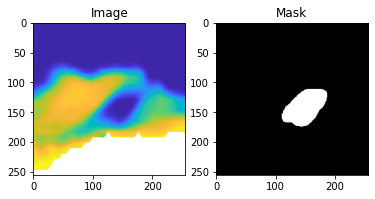

Labels are: [0 1] and label count is: [62356  3180]
Image Number= 16


In [ ]:
# Visualization before preprocessing

img_num = random.randint(0, len(train_images)-1)
V = visualize(train_images, mask_images, img_num)
V

In [ ]:
# Preprocessing for built-in Unet

X, Y = preprocessing(train_images,mask_images, backbone)

print(X.shape)
print(Y.shape)

(472, 256, 256, 3)
(472, 256, 256, 1)


In [ ]:
# Preprocessing for custom built Unet

X1, Y1 = preprocess_customUnet(train_images,mask_images)

print(X1.shape)
print(Y1.shape)

(472, 256, 256, 3)
(472, 256, 256, 1)


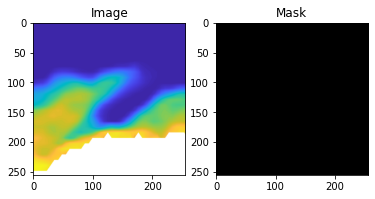

Labels are: [0.] and label count is: [65536]
Image Number= 273


In [ ]:
# Visualizing Preprocessed images

img_num = random.randint(0, len(X)-1)
VP = visualize(X,Y, img_num)
VP

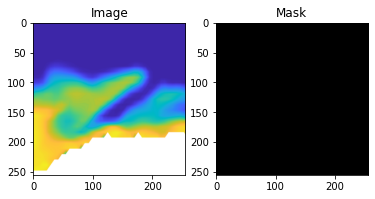

Labels are: [0.] and label count is: [65536]
Image Number= 272


In [ ]:
img_num = random.randint(0, len(X)-1)
VP1 = visualize(X1,Y1, img_num)
VP1

In [ ]:
# Data Split

x_train, y_train, x_val, y_val = data_split(X, Y, split_size = 0.2, random_state = 42)

print("Train Data Dynamics:" , x_train.shape, y_train.shape)
print("Test Data Dynamics:" , x_val.shape, y_val.shape)

Train Data Dynamics: (377, 256, 256, 3) (377, 256, 256, 1)
Test Data Dynamics: (95, 256, 256, 3) (95, 256, 256, 1)


In [ ]:
# Data Split

x_train1, y_train1, x_val1, y_val1 = data_split(X1, Y1, split_size = 0.2, random_state = 42)

print("Train Data Dynamics:" , x_train1.shape, y_train1.shape)
print("Test Data Dynamics:" , x_val1.shape, y_val1.shape)

Train Data Dynamics: (377, 256, 256, 3) (377, 256, 256, 1)
Test Data Dynamics: (95, 256, 256, 3) (95, 256, 256, 1)


**BUILDING AUTOENCODER MODEL AND SAVING WEIGHTS FOR UNET**

In [ ]:
# Build Autoencoder model and save weights to be added in unet training

autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss=mse, metrics=[acc])
AE = autoencoder.fit(X1, X1, epochs=30, verbose=1)


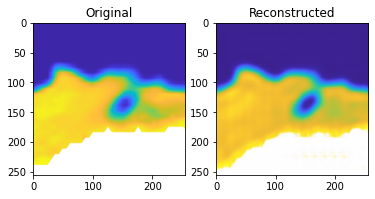

In [ ]:
# Visualize performance of autoencoder model

num = random.randint(0, len(train_images)-1)         # Random image number 

test_img = np.expand_dims(X1[num], axis=0)           # Input image      
pred = autoencoder.predict(test_img)                 # Prediction

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(256,256,3))
plt.title('Reconstructed')
plt.show()



In [ ]:
# Building Unet with encoder layers replaced with that of autoencoders

unet_model_weights = build_unet(input_shape)

#Set weights to encoder part of the U-net (first 35 layers taken from autoencoders)
for l1, l2 in zip(unet_model_weights.layers[:35], autoencoder.layers[0:35]):
    l1.set_weights(l2.get_weights())
unet_model_weights.compile(optimizer=optimizer, loss=binary_loss, metrics=[iou])
unet_model_weights.save(f'{saved_models}unet_model_weights.h5')

**TRAINING 3 MODELS**

In [ ]:
# Built-in UNET architecture from keras segmentation models. Transfer Learning using pre-trained encoder weights trained on 'imagenet'
# Batch size = 32 , Epochs = 100 

TransferLearning_wt_imagenet = sm.Unet(backbone, encoder_weights= 'imagenet')
TransferLearning_wt_imagenet.compile(optimizer=optimizer, loss= binary_loss, metrics=[iou])
history_TL1 = TransferLearning_wt_imagenet.fit(x=x_train, y= y_train, batch_size= BS32, epochs= 100, verbose=1, validation_data= (x_val, y_val))

85532672/85521592 [==============================] - 2s 0us/step
Epoch 1/100
12/12 [==============================] - 12s 500ms/step - loss: 0.4369 - iou_score: 0.0144 - val_loss: 0.7787 - val_iou_score: 1.9864e-10
Epoch 2/100
12/12 [==============================] - 3s 270ms/step - loss: 0.1649 - iou_score: 0.0288 - val_loss: 0.1967 - val_iou_score: 1.8996e-04
Epoch 3/100
12/12 [==============================] - 3s 271ms/step - loss: 0.0894 - iou_score: 0.0649 - val_loss: 0.2674 - val_iou_score: 0.0058
Epoch 4/100
12/12 [==============================] - 3s 271ms/step - loss: 0.0591 - iou_score: 0.1163 - val_loss: 0.2448 - val_iou_score: 0.0051
Epoch 5/100
12/12 [==============================] - 3s 270ms/step - loss: 0.0426 - iou_score: 0.1625 - val_loss: 0.1951 - val_iou_score: 0.0086
Epoch 6/100
12/12 [==============================] - 3s 271ms/step - loss: 0.0342 - iou_score: 0.1916 - val_loss: 0.1453 - val_iou_score: 0.0083
Epoch 7/100
12/12 [==============================] - 3s 

In [ ]:
# Saving Model and History

TransferLearning_wt_imagenet.save(f'{saved_models}TransferLearning_wt_imagenet.h5')
np.save(f'{saved_models}TransferLearning_wt_imagenet_history.npy', history_TL1.history)

In [ ]:
# Built-in UNet architecture from keras segmentation models. Trained with random encoder weights
# Batch size = 32 , Epochs = 100

transfered_unet_wt_randomweights = sm.Unet(backbone, encoder_weights= None)
transfered_unet_wt_randomweights.compile(optimizer=optimizer, loss= binary_loss, metrics=[iou])
history_TL2 = transfered_unet_wt_randomweights.fit(x=x_train, y= y_train, batch_size= BS32, epochs= 100, verbose=1, validation_data= (x_val, y_val))


Epoch 1/100
12/12 [==============================] - 11s 474ms/step - loss: 0.7039 - iou_score: 0.0104 - val_loss: 3792561.5000 - val_iou_score: 2.5507e-10
Epoch 2/100
12/12 [==============================] - 3s 271ms/step - loss: 0.3837 - iou_score: 0.0100 - val_loss: 10220211.0000 - val_iou_score: 8.9690e-11
Epoch 3/100
12/12 [==============================] - 3s 270ms/step - loss: 0.2565 - iou_score: 0.0107 - val_loss: 832503.8125 - val_iou_score: 1.6299e-10
Epoch 4/100
12/12 [==============================] - 3s 270ms/step - loss: 0.1787 - iou_score: 0.0154 - val_loss: 27622.6895 - val_iou_score: 2.9384e-10
Epoch 5/100
12/12 [==============================] - 3s 269ms/step - loss: 0.1261 - iou_score: 0.0252 - val_loss: 1316.4774 - val_iou_score: 2.6839e-10
Epoch 6/100
12/12 [==============================] - 3s 269ms/step - loss: 0.0926 - iou_score: 0.0368 - val_loss: 364.8745 - val_iou_score: 4.0447e-10
Epoch 7/100
12/12 [==============================] - 3s 270ms/step - loss: 0.0

In [ ]:
# Saving Model and History

transfered_unet_wt_randomweights.save(f'{saved_models}TransferLearning_wt_randomweights.h5')
np.save(f'{saved_models}TransferLearning_wt_randomweights_history.npy', history_TL2.history)

In [ ]:
# Designed UNET architecture with pretrained encoder weights using autoencoders.
# Batch size = 32 , Epochs = 100 

unet_wt_autoencoder_weights = build_unet(input_shape)
unet_wt_autoencoder_weights.load_weights(f'{saved_models}unet_model_weights.h5')

unet_wt_autoencoder_weights.compile(optimizer=optimizer, loss=binary_loss, metrics=[iou])
history_AE = unet_wt_autoencoder_weights.fit(x=x_train1, y= y_train1, batch_size= BS32, epochs= 100, verbose=1, validation_data= (x_val1, y_val1))

Epoch 1/100
12/12 [==============================] - 34s 1s/step - loss: 0.5161 - iou_score: 0.0114 - val_loss: 0.6105 - val_iou_score: 0.0145
Epoch 2/100
12/12 [==============================] - 10s 832ms/step - loss: 0.1823 - iou_score: 0.0128 - val_loss: 5.0615 - val_iou_score: 0.0129
Epoch 3/100
12/12 [==============================] - 10s 832ms/step - loss: 0.1182 - iou_score: 0.0142 - val_loss: 0.2126 - val_iou_score: 0.0210
Epoch 4/100
12/12 [==============================] - 10s 832ms/step - loss: 0.0981 - iou_score: 0.0169 - val_loss: 8.0329 - val_iou_score: 0.0127
Epoch 5/100
12/12 [==============================] - 10s 832ms/step - loss: 0.0835 - iou_score: 0.0219 - val_loss: 0.1353 - val_iou_score: 0.0114
Epoch 6/100
12/12 [==============================] - 10s 833ms/step - loss: 0.0699 - iou_score: 0.0446 - val_loss: 0.1762 - val_iou_score: 0.0122
Epoch 7/100
12/12 [==============================] - 10s 833ms/step - loss: 0.0603 - iou_score: 0.0812 - val_loss: 0.3145 - val

In [ ]:
# Saving model and History

unet_wt_autoencoder_weights.save(f'{saved_models}unet_wt_autoencoder_weights_model.h5')
np.save(f'{saved_models}unet_wt_autoencoder_history.npy', history_AE.history)

In [ ]:
# Loading Saved Models

TransferLearning_wt_imagenet = load_model(f'{saved_models}TransferLearning_wt_imagenet.h5', compile=False)
transfered_unet_wt_randomweights = load_model(f'{saved_models}TransferLearning_wt_randomweights.h5', compile=False)

In [ ]:
# Loading Saved History

history_TL1 = np.load(f'{saved_models}TransferLearning_wt_imagenet_history.npy', allow_pickle='TRUE').item()
history_TL2 = np.load(f'{saved_models}TransferLearning_wt_randomweights_history.npy', allow_pickle='TRUE').item()
history_TL3 = np.load(f'{saved_models}unet_wt_autoencoder_history.npy', allow_pickle='TRUE').item()

In [ ]:
# Comparing Mean Accuracy of 3 Models

accuracy1 = model_IOU(TransferLearning_wt_imagenet, x_val, y_val, 0.5)
accuracy2 = model_IOU(transfered_unet_wt_randomweights, x_val, y_val, 0.5)
accuracy3 = model_IOU(unet_wt_autoencoder_weights, x_val, y_val, 0.5)

print('IOU score of model "TransferLearning_wt_imagenet" is', f'{accuracy1:.0%}')
print('IOU score of model "TransferLearning_wt_randomweights" is', f'{accuracy2:.0%}')
print('IOU score of model "TransferLearning_wt_autoencoder_weights" is', f'{accuracy3:.0%}')

IOU score of model "TransferLearning_wt_imagenet" is 82%
IOU score of model "TransferLearning_wt_randomweights" is 78%
IOU score of model "TransferLearning_wt_autoencoder_weights" is 81%


**Comparison of IOU Accuracy over 100 Epochs**

In [ ]:
def compare_evaluation(history1, history2, history3, model1, model2, model3):

    val_acc1 = history1['val_iou_score']
    val_acc2 = history2['val_iou_score']
    val_acc3 = history3['val_iou_score']
    epochs = range(1, len(val_acc1) +1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, val_acc1,'xkcd:blue', label= f'{model1}')
    plt.plot(epochs, val_acc2, 'xkcd:orange', label=f'{model2}')
    plt.plot(epochs, val_acc3, 'xkcd:green', label=f'{model3}')
    plt.title('Comparison of Validation accuracy from three models')
    plt.xlabel('Epochs')
    plt.ylabel('IOU')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

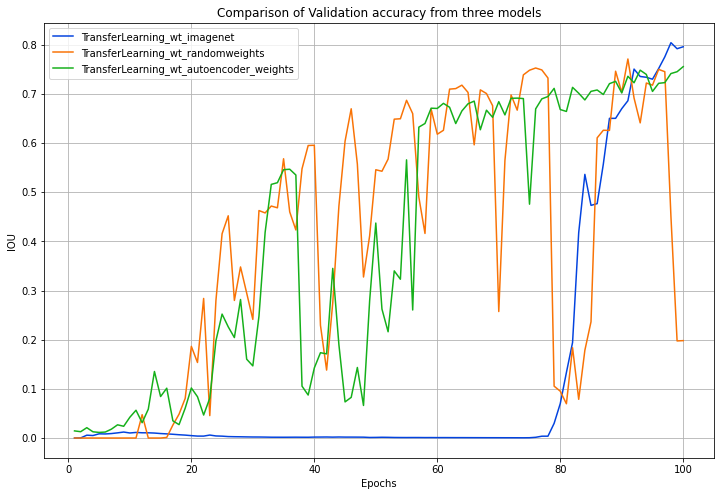

In [ ]:
# Compare history of 3 models

CE = compare_evaluation(history_TL1, history_TL2, history_TL3, model1 = 'TransferLearning_wt_imagenet', 
                          model2 = 'TransferLearning_wt_randomweights',
                          model3 = 'TransferLearning_wt_autoencoder_weights')
CE

**PERFORMANCE ON TEST IMAGES**

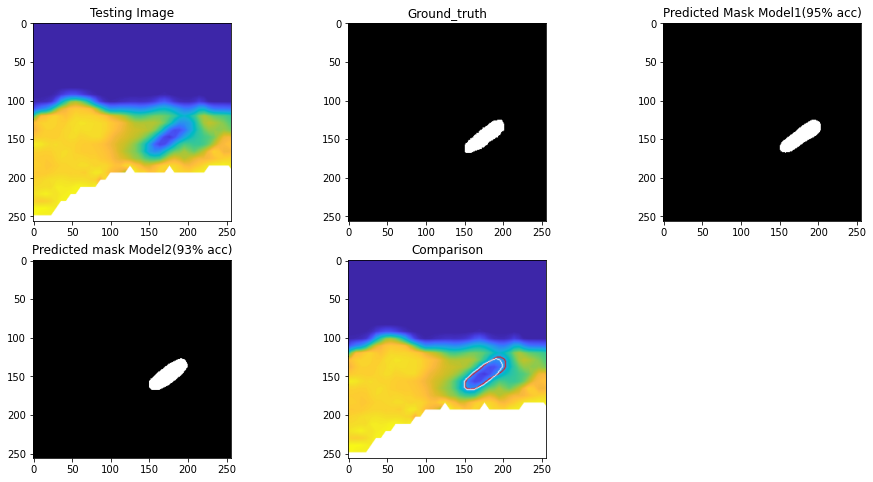

In [ ]:
# Comparison of Transfer Learning with imagenet weights vs Autoencoder weights

testing = compare_performance(x_val1, y_val1, TransferLearning_wt_imagenet , unet_wt_autoencoder_weights, 0.5)

#### ***03 - COMPARISON OF ORIGINAL AND AUGMENTED DATA***


*   Original Data
*   Augmented Data
*   Original and Augmented Data Using Autoencoders

In [ ]:
### DIRECTORY

drive_path = '/content/drive/MyDrive/Colab Notebooks/'
saved_models = '/content/drive/MyDrive/Colab Notebooks/saved_models/'
Train_path = "/data/Train_folder/OriginalTrain"
Mask_path =  "/data/Train_folder/AnnotationsTrain"
test_path = "/testdata/Testers"

### HYPER-PARAMETERS

# (Data Dynamics)
size = 256
IMG_CHANNELS = 3
input_shape = (size, size, IMG_CHANNELS)

# (Model Parameters)
iou = sm.metrics.iou_score
jaccard_loss = sm.losses.bce_jaccard_loss
binary_loss = 'binary_crossentropy'
optimizer = 'Adam'
backbone = 'resnet34'

# (Pretrained weights)
pretrained_EW = 'imagenet'

# (Batch Sizes)
BS16 = 16                            
BS32 = 32

In [ ]:
# Loading Image Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Train_folder.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [ ]:
# Loading Test Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Testers.zip', 'r')
zip_ref.extractall('/testdata')
zip_ref.close()

In [ ]:
# Loading Data
train_images, mask_images = load_data(Train_path, Mask_path, size)

print(train_images.shape)
print(mask_images.shape)

(472, 256, 256, 3)
(472, 256, 256)


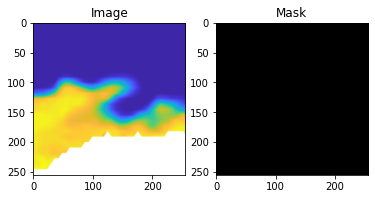

Labels are: [0] and label count is: [65536]
Image Number= 146


In [ ]:
# Visualization before preprocessing

img_num = random.randint(0, len(train_images)-1)
V = visualize(train_images, mask_images, img_num)
V

In [ ]:
# Preprocessing for transferred/built-in Unet

X, Y = preprocess_customUnet(train_images,mask_images)

print(X.shape)
print(Y.shape)

(472, 256, 256, 3)
(472, 256, 256, 1)


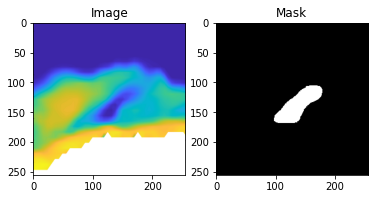

Labels are: [0. 1.] and label count is: [63036  2500]
Image Number= 429


In [ ]:
# Visualizing Preprocessed images

img_num = random.randint(0, len(X)-1)
VP = visualize(X,Y, img_num)
VP

In [ ]:
# Data Split

x_train, y_train, x_val, y_val = data_split(X, Y, split_size = 0.2, random_state = 42)

print("Train Data Dynamics:" , x_train.shape, y_train.shape)
print("Test Data Dynamics:" , x_val.shape, y_val.shape)

Train Data Dynamics: (377, 256, 256, 3) (377, 256, 256, 1)
Test Data Dynamics: (95, 256, 256, 3) (95, 256, 256, 1)


**ORIGINAL DATA**

In [ ]:
# Building custom built Unet architecture for training original dataset (without using pretrained autencoder weights)

original_unet = build_unet(input_shape)                                   # Designed Unet function
original_unet.compile('Adam', loss= binary_loss, metrics= [iou]) 

history_orig = original_unet.fit(x=x_train, y= y_train, batch_size= 32, epochs= 100, verbose=1, validation_data= (x_val, y_val))

Epoch 1/100
12/12 [==============================] - 15s 974ms/step - loss: 0.4493 - iou_score: 0.0144 - val_loss: 16.2463 - val_iou_score: 0.0119
Epoch 2/100
12/12 [==============================] - 11s 919ms/step - loss: 0.1775 - iou_score: 0.0148 - val_loss: 1614.4230 - val_iou_score: 0.0115
Epoch 3/100
12/12 [==============================] - 11s 919ms/step - loss: 0.1066 - iou_score: 0.0194 - val_loss: 440.0432 - val_iou_score: 0.0116
Epoch 4/100
12/12 [==============================] - 11s 920ms/step - loss: 0.0824 - iou_score: 0.0329 - val_loss: 2411.3447 - val_iou_score: 0.0118
Epoch 5/100
12/12 [==============================] - 11s 919ms/step - loss: 0.0693 - iou_score: 0.0705 - val_loss: 118.7013 - val_iou_score: 0.0120
Epoch 6/100
12/12 [==============================] - 11s 919ms/step - loss: 0.0598 - iou_score: 0.0921 - val_loss: 175.4968 - val_iou_score: 0.0124
Epoch 7/100
12/12 [==============================] - 11s 917ms/step - loss: 0.0525 - iou_score: 0.1204 - val_lo

In [ ]:
# Accuracy
accuracy1 = model_IOU(original_unet, x_val, y_val, 0.5)
print('IOU score of model "original_unet" is', f'{accuracy1:.0%}')

IOU score of model "original_unet" is 81%


In [ ]:
# Saving model and history
original_unet.save(f'{saved_models}custom_unet_original.h5')

# Saving history
np.save(f'{saved_models}custom_unet_original_history.npy', history_orig.history)


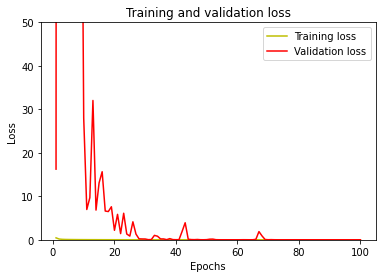

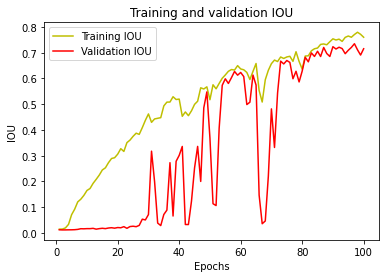

In [ ]:
# Evaluation of Training and Validation Loss and Accuracy

EV1 = evaluation(history_orig)

**AUGMENTED DATA**

In [ ]:
# Data Augmentation (using designed Augment Fnction)

train_generator, val_generator, trainImage_generated, trainMask_generated = augment(X, Y, 0.2)

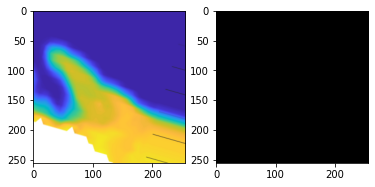

Labels [0.]


In [ ]:
# Visualize generated images

VG = visualize_generated(trainImage_generated,trainMask_generated)

In [ ]:
# Building custom Unet architecture for training augmented dataset (without pretrained autoencoder weights)

augmented_unet = build_unet(input_shape)                                   
augmented_unet.compile(optimizer= optimizer, loss= binary_loss, metrics= [iou]) 

history_aug = augmented_unet.fit_generator(train_generator, validation_data= val_generator, steps_per_epoch= 50, validation_steps= 50, epochs= 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
50/50 [==============================] - 71s 1s/step - loss: 0.3022 - iou_score: 0.0136 - val_loss: 200.5132 - val_iou_score: 0.0115
Epoch 2/100
50/50 [==============================] - 68s 1s/step - loss: 0.0928 - iou_score: 0.0206 - val_loss: 0.3821 - val_iou_score: 0.0125
Epoch 3/100
50/50 [==============================] - 68s 1s/step - loss: 0.0641 - iou_score: 0.0570 - val_loss: 0.1207 - val_iou_score: 0.0333
Epoch 4/100
50/50 [==============================] - 68s 1s/step - loss: 0.0466 - iou_score: 0.1074 - val_loss: 0.0672 - val_iou_score: 0.0390
Epoch 5/100
50/50 [==============================] - 68s 1s/step - loss: 0.0360 - iou_score: 0.1526 - val_loss: 0.0859 - val_iou_score: 0.0753
Epoch 6/100
50/50 [==============================] - 68s 1s/step - loss: 0.0298 - iou_score: 0.2003 - val_loss: 0.0886 - val_iou_score: 0.0805
Epoch 7/100
50/50 [==============================] - 68s 1s/step - loss: 0.0266 - iou_score: 0.2339 - val_loss: 0.0408 - val_iou_score: 0.12

In [ ]:
# Mean Accuracy
accuracy2 = model_IOU(augmented_unet, x_val, y_val, 0.5)
print('IOU score of model "augmented_unet" is', f'{accuracy2:.0%}')

IOU score of model "augmented_unet" is 82%


In [ ]:
# Saving model and history
augmented_unet.save(f'{saved_models}custom_unet_augmented.h5')
np.save(f'{saved_models}custom_unet_augmented_history.npy', history_aug.history)

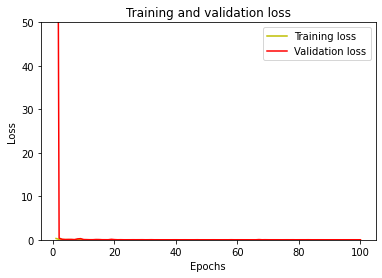

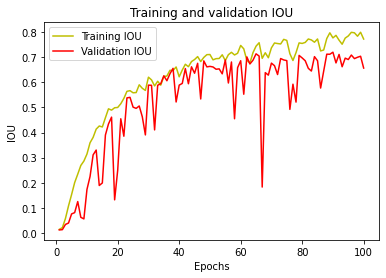

In [ ]:
# Evaluation of Training and Validation Loss and Accuracy
EV2 = evaluation(history_aug)

**Comparison of original vs augmented data history**

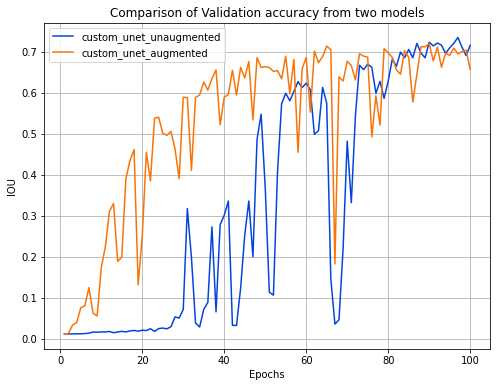

In [ ]:
CE2 = compare_evaluation_2(history_orig, history_aug, model1 = 'custom_unet_unaugmented', 
                          model2 = 'custom_unet_augmented')

**PERFORMANCE OF TWO MODELS ON TEST DATA**

In [ ]:
original_unet = load_model(f'{saved_models}custom_unet_original.h5', compile=False)
augmented_unet = load_model(f'{saved_models}custom_unet_augmented.h5', compile=False)

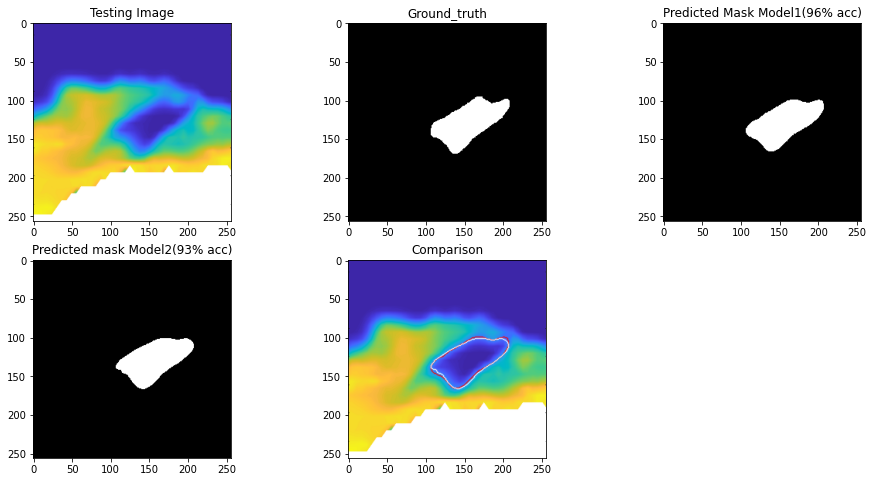

In [ ]:
# Comparison of Transfer Learning with imagenet weights vs Autoencoder weights

testing = compare_performance(x_val, y_val, original_unet , augmented_unet, 0.5)

**USING AUGMENTATION WITH PRETRAINED AUTOENCODER WEIGHTS**

In [ ]:
# Building designed Unet architecture for training augmented dataset using pretrained autoencoders weights

augmented_unet = build_unet(input_shape)                                   # Custom built Unet function
augmented_unet.load_weights(f'{saved_models}unet_model_weights.h5')        # Loading pretrained weights

augmented_unet.compile('Adam', loss= binary_loss, metrics= [iou]) 

history_aug_pretrained = augmented_unet.fit_generator(train_generator, validation_data= val_generator, steps_per_epoch= 50, validation_steps= 50, epochs= 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
50/50 [==============================] - 85s 2s/step - loss: 0.2228 - iou_score: 0.0151 - val_loss: 11.5967 - val_iou_score: 0.0139
Epoch 2/100
50/50 [==============================] - 69s 1s/step - loss: 0.0702 - iou_score: 0.0503 - val_loss: 0.1810 - val_iou_score: 0.0193
Epoch 3/100
50/50 [==============================] - 69s 1s/step - loss: 0.0469 - iou_score: 0.1096 - val_loss: 0.6002 - val_iou_score: 0.0256
Epoch 4/100
50/50 [==============================] - 69s 1s/step - loss: 0.0357 - iou_score: 0.1694 - val_loss: 0.2632 - val_iou_score: 0.0507
Epoch 5/100
50/50 [==============================] - 70s 1s/step - loss: 0.0276 - iou_score: 0.2301 - val_loss: 0.1362 - val_iou_score: 0.0942
Epoch 6/100
50/50 [==============================] - 69s 1s/step - loss: 0.0235 - iou_score: 0.2785 - val_loss: 0.0748 - val_iou_score: 0.1649
Epoch 7/100
50/50 [==============================] - 69s 1s/step - loss: 0.0194 - iou_score: 0.3393 - val_loss: 0.0384 - val_iou_score: 0.254

In [ ]:
# Mean Accuracy

accuracy3 = model_IOU(augmented_unet, x_val, y_val, 0.5)
print('IOU score of model "augmented_unet_pretrained" is', f'{accuracy3:.0%}')

IOU score of model "augmented_unet_pretrained" is 81%


In [ ]:
# Saving model and history

augmented_unet.save(f'{saved_models}augmented_unet_pretrained.h5')
np.save(f'{saved_models}augmented_unet_pretrained_history.npy', history_aug_pretrained.history)

**Comparison of Augmented Unet with and without pretrained weights**

In [ ]:
# Loading previosuly experimented augmented Unet history

history_aug = np.load(f'{saved_models}custom_unet_augmented_history.npy', allow_pickle='TRUE').item()

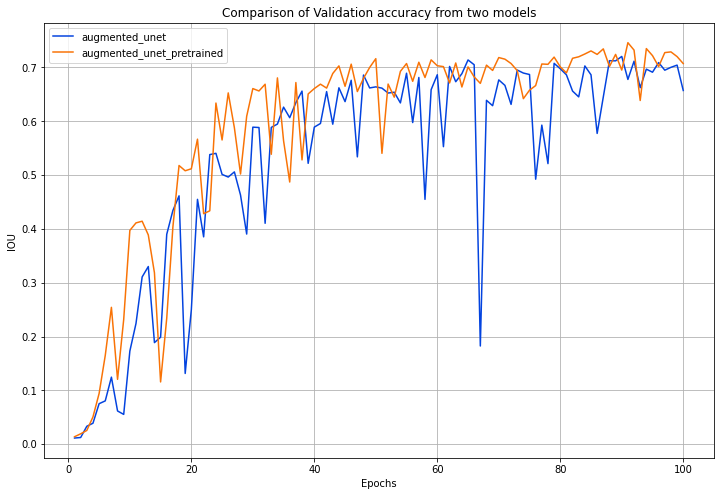

In [ ]:
val_acc1 = history_aug['val_iou_score']
val_acc2 = history_aug_pretrained.history['val_iou_score']

epochs = range(1, len(val_acc1) +1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, val_acc1,'xkcd:blue', label= f'augmented_unet')
plt.plot(epochs, val_acc2, 'xkcd:orange', label=f'augmented_unet_pretrained')
plt.title('Comparison of Validation accuracy from two models')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.grid()
plt.show()

**Comparison of Performance (Augmented Unet with and without pretrained Autoencoder Weights)**

In [ ]:
# Loading Saved models

custom_unet_augmented = load_model(f'{saved_models}custom_unet_augmented.h5', compile=False)
augmented_unet_pretrained = load_model(f'{saved_models}augmented_unet_pretrained.h5', compile=False)

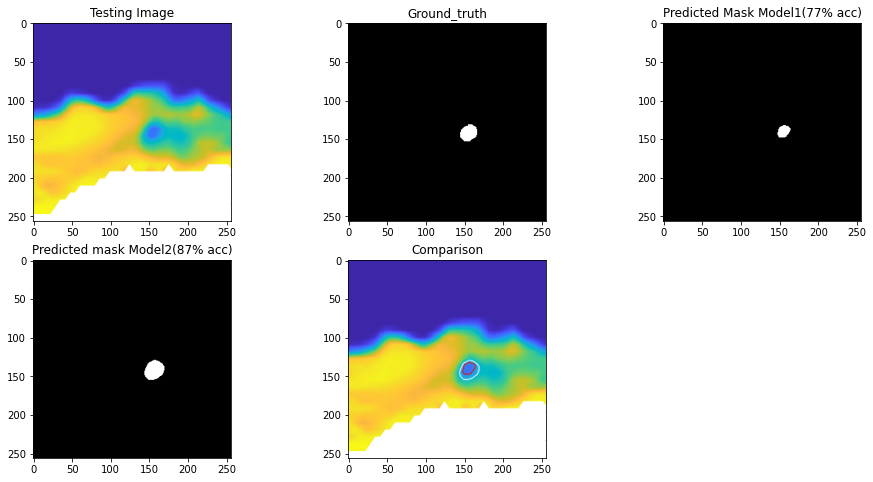

In [ ]:
# Comparison of Augmented Unet model with and without Pretrained Autoencoder weights

testing = compare_performance(x_val, y_val, custom_unet_augmented , augmented_unet_pretrained, 0.8)

**TESTING ON UNSEEN DATA**

In [ ]:
augmented_unet_pretrained = load_model(f'{saved_models}augmented_unet_pretrained.h5', compile=False)
original_unet = load_model(f'{saved_models}custom_unet_original.h5', compile=False)
original_unet_pretrained = load_model(f'{saved_models}unet_wt_autoencoder_weights_model.h5', compile=False)

In [ ]:
# Testing on Unseen Data 

tester_img = load_test_data(test_path, size)
print(tester_img.shape)

(32, 256, 256, 3)


No Polynya Detected


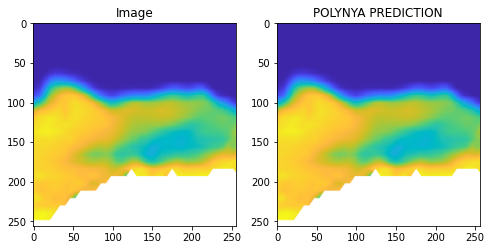

Image number: 31


In [ ]:
# Model Unet trained on original dataset without pretrained weights

img_num = random.randint(0, len(tester_img)-1)
T2 = testing(tester_img, original_unet, 0.8, img_num=31)